# Spatial Regression of Abundance Data
---
***
Here I show how to extract different taxonomic information at cell level.
Although there exists a method for building the taxonomic tree within a single cell, the process can be computationally intensive because it depends on extracting the total amount of occurrences in each cell. From there, it traverses fromtop to bottom the tree looking for the corresponding nodes.

The approach is usefull when one needs a small number of trees but it'll become increasingly slow if the amount of cells or occurrences increases. 

---

## Extracting specific taxonomic levels en each cells

The method studied here makes use of the relationship type `IS_IN` stored in the knowledge graph.

> Note: *There was a problem with the design of the OGM implementation (py2neo.ogm). The retrieval of linked nodes based on a specific relation does not distinguish different labels. In other words it returns the totality of the data that has the  specific relationship given a node.*

> Patchy solution: 
The solution was to include extra methods for the class Cell `has_[taxas]`. This method/attribute returns a graph selector that points to the corresponding nodes.

> Stabile Fix 
Make relationships as specific as possible (given the data). For example, if instead of using the relation type 
* *IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell) 
change it to:
* *Family_IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell)
Let's get started.
As usual we need to load the necessary modules


In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

## Random selection of cells.

*Note* : There was a big problem in the data arquitecture. For storage reasons I couldn't load the complete world bioclimatic layers. Therefore I needed to put a regional subset that comprises only the Mexican Territory. 
For this reason, it is necessary that any approach for selecting subsamples needs to be constrained (filter) by this geometry. 
We can do that with this:

In [2]:
from sketches.models import Country
from mesh.models import MexMesh

Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

In [3]:
# Get all cell ids
ids = list(mexican_cells.values('pk'))

In [4]:
from traversals.sampling import UniformRandomCellSample

In [5]:
CellNodeClass = Mex4km
list_of_cell_ids = ids
n = len(ids)
selection_of_cells = UniformRandomCellSample(ids,Mex4km,sample_size=200,random_seed=12345,with_replacement=True)

INFO Using custom random seed of: 12345
INFO:biospytial.graph_models:Using custom random seed of: 12345
INFO Compiling Query and asking the Graph Database
INFO:biospytial.graph_models:Compiling Query and asking the Graph Database


The selection should be as follow:
    * Convert to pandas
    * Generate random numbers uniform on that range
    * use iloc to get the id values
    * Use the normal methodology.
    

## Extract richness and Environmental covariates from cells at a given taxonomic level
Options are: Family, Order, Spicies, etc

In [6]:
from traversals import strategies as st

In [7]:
%time data = st.getEnvironmentAndRichnessFromListOfCells(list_of_cells=selection_of_cells,taxonomic_level_name='Family')

CPU times: user 21.1 s, sys: 764 ms, total: 21.9 s
Wall time: 1min 59s


It takes time because it need to calculate on the fly the summary statistic of each cell. It is using the postgis backend

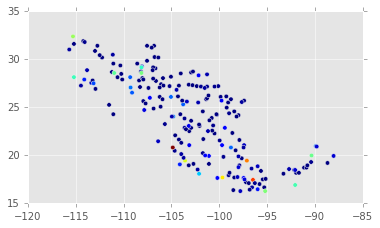

In [8]:
data.plot(column='n.Family')

In [9]:
from external_plugins.spystats.spystats import tools as tl

In [10]:
vg = tl.Variogram(data,response_variable_name='n.Family')

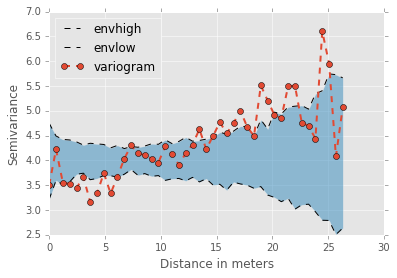

In [11]:
vg.plot(with_envelope=True)

## Let's bring some models

In [12]:
m1 = tl.ExponentialVariogram(nugget=3.5,range_a=15,sill=6.5)
m2 = tl.GaussianVariogram(nugget=3.5,range_a=15,sill=6.5)
m4 = tl.SphericalVariogram(nugget=3.5,range_a=15,sill=6.5)

In [13]:
vg.fitVariogramModel(m2)

< Gaussian Variogram : sill 5.56023920431, range 17.4020551862, nugget 3.53000261509 >

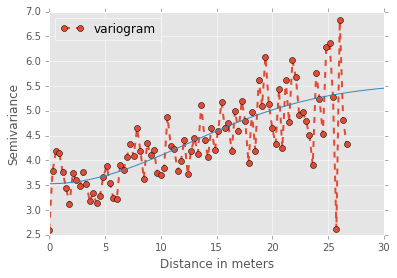

In [14]:
x = np.linspace(0,30,100)

vg.plot(with_envelope=False,n_bins=100)
plt.plot(x,vg.model.f(x))



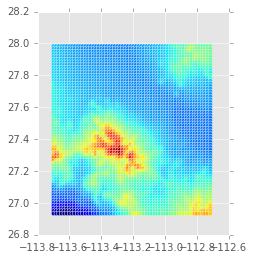

In [57]:
## We will retrieve environmental data from another region using the 'raster_api'
##We will do it like this:
cell = selection_of_cells.first()
## Go up 5 scales
upcell = cell.upperCell.next().upperCell.next().upperCell.next().upperCell.next().upperCell.next()
## Get the raster for this area, example Elevation
elev = upcell.getAssociatedRasterAreaData('Elevation')
## Get a dataframe
data_star = elev.toPandasDataFrame()
## Convert it to geoDataFrame
data_star = tl.toGeoDataFrame(data_star,xcoord_name='Longitude',ycoord_name='Latitude')
## Remove NAs
data_star = data_star.dropna()
## Plot it
data_star.plot(column=0)
##

# Bayesian Modelling


In [58]:
import pymc3 as pm
data.columns = [u'n_Family', u'Longitude', u'Latitude', u'Elevation_mean',
       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'WindSpeed_mean', u'geometry']

In [59]:
from statsmodels.genmod.generalized_linear_model import GLM
glmodel = GLM.from_formula('n_Family ~ Elevation_mean',data=data)
res = glmodel.fit()
print(res.summary())


z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])

                 Generalized Linear Model Regression Results                  
Dep. Variable:               n_Family   No. Observations:                  199
Model:                            GLM   Df Residuals:                      197
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                   123.382814666
Method:                          IRLS   Log-Likelihood:                -760.49
Date:                Tue, 27 Feb 2018   Deviance:                       24306.
Time:                        21:56:39   Pearson chi2:                 2.43e+04
No. Iterations:                     4                                         
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          4.1630      1.267      3.287      0.001         1.681     6.645
Elevation_mean     0.0007      0.001    

In [60]:
## cero coef for long lat
z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])
print(coefs)

[ 0.          0.          0.00066554]


In [79]:
## Analysis, GP only one parameter to fit
# The variational method is much beter.
from pymc3.variational.callbacks import CheckParametersConvergence

with pm.Model() as model:
    sigma = 1.0
    #range_a=10.13
    
    
    tau = pm.Uniform('tau',0,5.0)
    #sigma = pm.Flat('sigma')
    #phi = pm.HalfNormal('phi',mu=8,sd=3)
    #phi = pm.Uniform('phi',6,12)
    phi = pm.Uniform('phi',0,15)
    
    Tau = pm.gp.cov.Constant(tau)
    
    cov = sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1]) + Tau
    #K = cov(grid[['Lon','Lat']].values)
    #phiprint = tt.printing.Print('phi')(phi)
    
    
    mf = pm.gp.mean.Linear(coeffs=coefs,intercept=res.params.values[0])

    
    
    
    
    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    
    
    
    
    
    ## I don't know why this
    #f = gp.prior("latent_field", X=data[['Longitude','Latitude']].values,reparameterize=False)
    
    f = gp.prior("latent_field", X=data[['Longitude','Latitude','Elevation_mean']].values,reparameterize=False)
    
    
    
    
    
    
    
    #f_print = tt.printing.Print('latent_field')(f)
    
    y_obs = pm.Poisson('y_obs',mu=np.exp(f),observed=data[['n_Family']].values)
    
    #y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)

    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    #%time trace = pm.sample(5000,step)#,tune=0,chains=1)
    ## Variational
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)

#with model:    
    
    ## For predicting
    %time f_star = gp.conditional("f_star", data_star.iloc[:,:3].values)
                    
#with model:
    ## sampling predictions posterior predictive checks
    pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=10)

                    


Average Loss = 3.1317e+05: 100%|██████████| 11000/11000 [01:02<00:00, 175.69it/s]

CPU times: user 4min 6s, sys: 3.99 s, total: 4min 10s
Wall time: 1min 5s
CPU times: user 1.98 s, sys: 40 ms, total: 2.02 s
Wall time: 1.34 s
CPU times: user 6.47 s, sys: 788 ms, total: 7.26 s


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


Wall time: 2.65 s


In [89]:
preds = pd.DataFrame(pred_samples['f_star'])

In [93]:
data_star['pred'] = preds.mean()

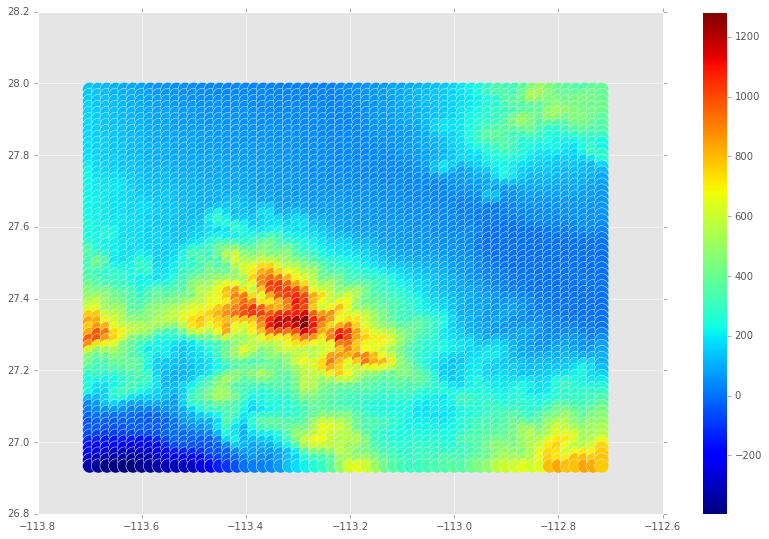

In [117]:
fig, ax = plt.subplots(figsize=(14, 9));
plt.scatter(data_star.Longitude,data_star.Latitude,c=data_star.iloc[:,0],s=200)
plt.colorbar()
#plt.scatter(data_star.Longitude,data_star.Latitude,c=data_star.pred,s=20,alpha=0.8)



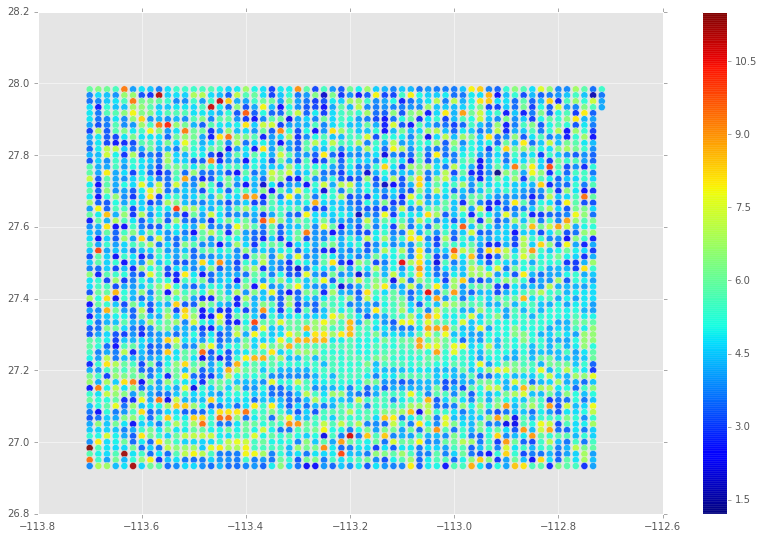

In [118]:
fig, ax = plt.subplots(figsize=(14, 9));
plt.scatter(data_star.Longitude,data_star.Latitude,c=np.exp(data_star.pred),s=50,alpha=0.9)
plt.colorbar()
#plt.scatter(gdata.Longitude,gdata.Latitude,c='k',s=gdata.Nsp,alpha=0.5)

In [ ]:
# For experiment

minx = min(data.Longitude)
maxx = max(data.Longitude)
miny = min(data.Latitude)
maxy = max(data.Latitude)
grid_sizex = 100
grid_sizey = 100
grid = tl.createGrid(grid_sizex=grid_sizex,grid_sizey=grid_sizey,minx=minx,miny=miny,maxx=maxx,maxy=maxy)

nx = np.linspace(minx,maxx,grid_sizex)
ny = np.linspace(miny,maxy,grid_sizey)
xx, yy = np.meshgrid(nx,ny)

In [ ]:
#map_estimate = find_MAP(model=model)
#map_estimate

In [ ]:
f_startartartar

## Here development for getting environmental covariates for each cell
Let's bring the environmental value per cell

In [ ]:
cell = selection_of_cells.first()

* Sacar las celdas superiores hasta sacar una marca lloraras
* luego extraer la informacion raster en matriz
* usar la transformacion affin para generar coordenadas
* aplicar al modelo. con pymc3
* primero lineal y luego con gam o algo asi,


In [ ]:
c = c_iter.next()

In [ ]:
env_data = c.getAssociatedRasterAreaData('MeanTemperature')

In [ ]:
c.polygon.wkt

In [ ]:
env_data.getRaster()

In [ ]:
rast = c.getAssociatedRasterAreaData('Elevation')

In [ ]:
rast.display_field()

## Let's see if we can get data from the upper scales


In [ ]:
c.upperCell.next()

In [ ]:
big_cell = c.upperCell.next().upperCell.next().upperCell.next()

In [ ]:
rr = big_cell.getAssociatedRasterAreaData('Elevation')

In [ ]:
rr.display_field()

In [ ]:
cells = list(selection_of_cells)

In [ ]:
%time tii = st.getEnvironmentalCovariatesFromListOfCells(cells)

In [ ]:
tii

### Benchmarking time for retrieval using explicit lists vs lazy-evaluation


In [ ]:
%time samples = list(sel)

In [ ]:
%time ocs2 = map(lambda c : list(c.has_occurrences),samples)

In [ ]:
ocs2_l = filter(lambda k : k != [] ,ocs2)

In [ ]:
len(ocs2_l)

In [ ]:
lll = reduce(lambda a,b : a+b,ocs2_l)

In [ ]:
lll

In [ ]:
lll == ccc

In [ ]:
sel = Mex4km.select(graph).where("_.id IN  %s "%str(c))

In [ ]:
def _try_levelnames_extraction(relationship):
    """
    Extracts the end node relationship name.
    for use with map functions.
    """
    try:
        a = relationship.start_node()['levelname']
        return a
    except:
        return None
    
types = map(lambda r : map(lambda t : _try_levelnames_extraction(t),r),available_rels)

In [ ]:
types

In [ ]:
tt = tb.buildTreeNeo(samples[26])

In [ ]:
#For now not run
#big_tree = reduce(lambda a,b : a+b , trees)
import seaborn as sns

In [ ]:
t = trees[2]

In [ ]:
ll = map(lambda t : t.richness , trees)

In [ ]:
sns.distplot(ll)

In [ ]:
tl.plotTree(tt)

In [ ]:
import traversals.strategies as strg

In [ ]:
type(root)

In [ ]:
root = t.node

In [ ]:
a = strg.getPresencesForNode(root,trees)

In [ ]:
data_t = strg.getPresencesForListOfNodes([root],trees)

In [ ]:
data_t

# The model

In [ ]:
import pymc3 as pm

In [ ]:
from pymc3 import find_MAP
map_estimate = find_MAP(model=model)
map_estimate

In [ ]:
import pandas as pd

In [ ]:
mapxy = pd.concat([data_t[['Longitude','Latitude']],pd.DataFrame({'map': map_estimate['latent_field']})],axis=1)

In [ ]:
gmapxy = tools.toGeoDataFrame(mapxy,xcoord_name='Longitude',ycoord_name='Latitude')

In [ ]:
fig, ax = plt.subplots(figsize=(14, 9));
gmapxy.plot(ax=ax,column='map')

## Prediction
The conditional method creates the conditional, or predictive, distribution over the latent function at arbitrary x∗x∗ input points, f(x∗)f(x∗). To construct the conditional distribution we write:

In [ ]:
minx = min(data_t.Longitude)
maxx = max(data_t.Longitude)
miny = min(data_t.Latitude)
maxy = max(data_t.Latitude)

In [ ]:
from external_plugins.spystats.spystats import tools

In [ ]:
grid = tools.createGrid(grid_sizex=10,grid_sizey=10,minx=minx,miny=miny,maxx=maxx,maxy=maxy)

In [ ]:
gp.predict(grid[['Lon','Lat']])

In [ ]:
%time f_star = gp.conditional("f_star", X=grid[['Lon','Lat']])

In [ ]:
getdata = lambda tree : tree.associatedData.getEnvironmentalVariablesCells()

In [ ]:
ts[1].associatedData.getEnvironmentalVariablesCells()

In [ ]:
list(choices)

In [ ]:
n